# 反转策略：均值回归_Mean Reverting Strategy


### 策略思想

均值回归策略应用了股市投资中经典的高抛低吸思想，
该类型策略一般在震荡市中表现优异；
但是在单边趋势行情中一般表现糟糕，往往会大幅跑输市场；

本策略逻辑：
股价超出过去n天均值达到x阈值则开空仓，回归均值后平仓。
股价低于过去n天均值达到x阈值则开多仓，回归均值后平仓。

In [1]:
import numpy as np
import pandas as pd
import tushare as ts

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

import warnings; warnings.simplefilter('ignore')       #忽略警告信息；

### 前言

In [2]:
# 回顾关于position信号处理中的np.NaN and Fillna() 使用：

a = pd.DataFrame([np.NaN,1,1,np.NaN,np.NaN,np.NaN,np.NaN,0,0,0])

In [3]:
a

,0
0,NaN
1,1.0
2,1.0
3,NaN
4,NaN
5,NaN
6,NaN
7,0.0
8,0.0
9,0.0


In [4]:
a.fillna(0)

,0
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [5]:
a.ffill()  #涉及NaN的应用和处理；向前填充；

,0
0,NaN
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,0.0
8,0.0
9,0.0


In [6]:
a.bfill()  #涉及NaN的应用和处理；向后填充；

,0
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


### 1. 数据准备 & 回测准备

In [7]:
hs300 = ts.get_k_data('hs300', start = '2010-08-11', end='2020-08-12')[['date','close']]

In [8]:
hs300.tail()

,date,close
2574,2020-08-06,4762.76
2575,2020-08-07,4707.93
2576,2020-08-10,4724.87
2577,2020-08-11,4681.78
2578,2020-08-12,4647.64


In [9]:
hs300.set_index('date', inplace = True)

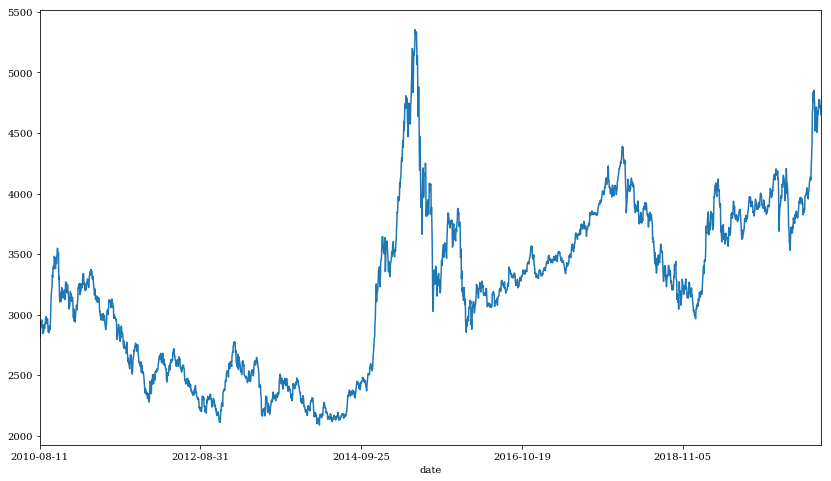

In [10]:
hs300['close'].plot(figsize = (14,8))

### 2. 策略开发思路

In [11]:
hs300['returns'] = np.log(hs300['close'] / hs300['close'].shift(1))

In [12]:
SMA = 50
hs300['SMA_%dd' %SMA]=hs300['close'].rolling(SMA).mean()

In [13]:
hs300.tail()

,close,returns,SMA_50d
date,,,
2020-08-06,4762.76,-0.003008,4361.7558
2020-08-07,4707.93,-0.011579,4379.0022
2020-08-10,4724.87,0.003592,4396.3670
2020-08-11,4681.78,-0.009162,4412.6622
2020-08-12,4647.64,-0.007319,4426.1882


In [14]:
TH = 225  #threshold 阈值

In [15]:
hs300['Dist'] = hs300['close'] - hs300['SMA_%dd' %SMA]

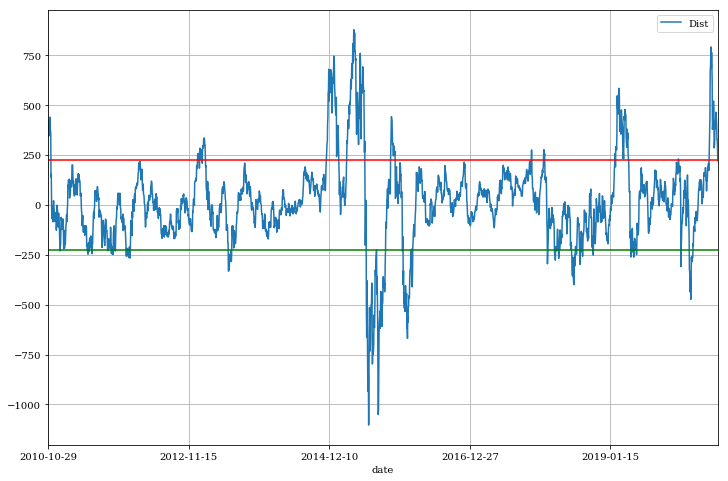

In [16]:
hs300['Dist'].dropna().plot(figsize = (12,8),legend = True, grid = True)
plt.axhline(TH, color = 'r')
plt.axhline(-TH, color = 'g')

In [17]:
hs300['position'] = np.where(hs300['Dist'] > TH, -1, np.nan) #寻找开空仓节点
hs300['position'] = np.where(hs300['Dist'] < -TH, 1, hs300['position']) #寻找开多仓节点
hs300['position'] = np.where(hs300['Dist'] * hs300['Dist'].shift(1) < 0, 0, hs300['position']) #寻找平仓节点
hs300['position'] = hs300['position'].ffill().fillna(0)  # 向前填充

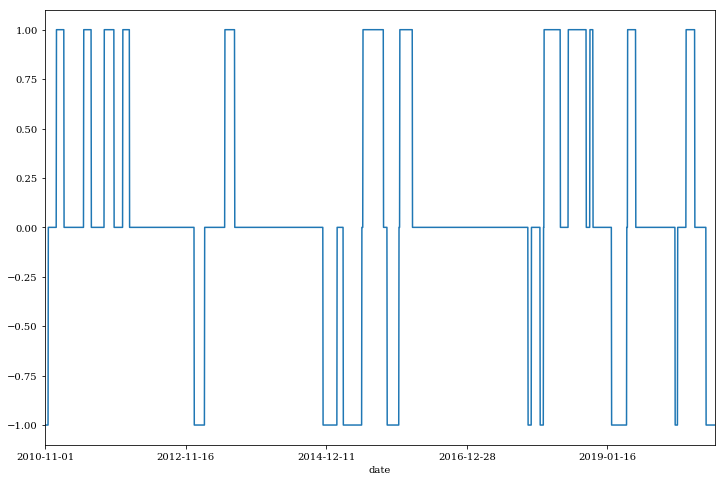

In [18]:
hs300['position'].ix[SMA:].plot(ylim = [-1.1,1.1], figsize = (12,8))

### 3. 计算策略年化收益并可视化

In [19]:
hs300['strategy'] = hs300['position'].shift(1) * hs300['returns']

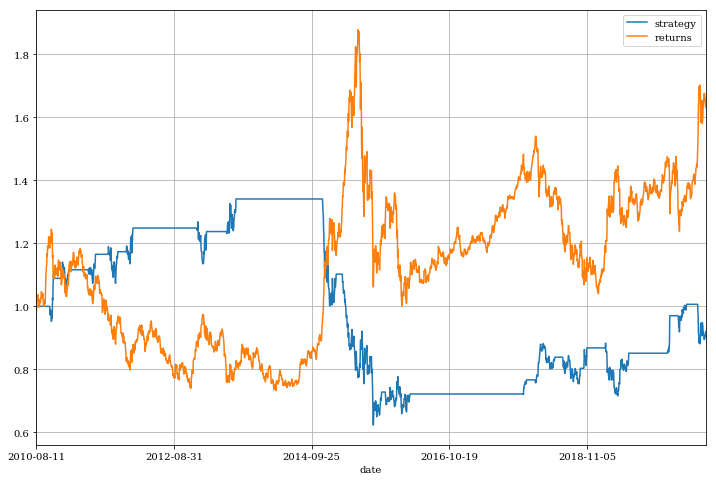

In [20]:
hs300[['strategy','returns']].cumsum().apply(np.exp).plot (figsize = (12,8),grid = True)